In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install vaderSentiment -qqq
!pip install transformers==2.11.0 -qqq

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
%matplotlib inline

import re
import json
import string, collections, unicodedata
import random

import nltk
nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')

from transformers import BertTokenizer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [4]:
news_df = pd.read_csv("/content/drive/MyDrive/297_BERT_Stocks/data/news/all_news")
news_df

,company_name,title,article,source
0,apple,New York City Mayor-Elect Eric Adams says he w...,New York City Mayor-Elect Eric Adams took to T...,Business Insider
1,apple,Zia Credit Union review: Hispanic American-led...,Personal Finance Insider writes about products...,Business Insider
2,apple,10 things in tech you need to know,"Hello, world. We've got news about a new way t...",Business Insider
3,apple,5 ways I'm using credit card points to cover 7...,This post contains links to products from our ...,Business Insider
4,apple,Sen. Mitt Romney dresses up as Ted Lasso in Ha...,Sen. Mitt Romney of Utah donned one of this ye...,Business Insider
...,...,...,...,...
151,netflix,Hollywood Union Approves Contracts With Studio...,One of Hollywoods most powerful unions approve...,Bloomberg
152,netflix,South Korea's Moment Owes More to Samsung Than...,South Korea is having a moment. Between the hi...,Bloomberg
153,netflix,Disney+ is launching a special IMAX format for...,Disney+ is bringing IMAXs Expanded Aspect Rati...,TechCrunch
154,netflix,"When Amazon Buys MGM, Hollywood Fears the Loss...",Where Hollywood and Silicon Valley collildeGet...,Bloomberg


In [5]:
with open('/content/drive/MyDrive/297_BERT_Stocks/common_word_phrases.json', 'r') as f:
    phrases_dict = json.load(f)
phrases = phrases_dict['phrases']

In [6]:
stop_words = {"i", "me", "my", "myself", "we", "our", "ours", "ourselves",
             "you", "your", "yours", "yourself", "yourselves", "he", "him",
             "his", "himself", "she", "her", "hers", "herself", "it", "its",
             "itself", "they", "them", "their", "theirs", "themselves", "what",
             "which", "who", "whom", "this", "that", "these", "those", "am", "is",
             "are", "was", "were", "be", "been", "being", "have", "has", "had",
             "having", "do", "does", "did", "doing", "a", "an", "the", "and",
             "but", "if", "or", "because", "as", "until", "while", "of", "at",
             "by", "for", "with", "about", "against", "between", "into", "through",
             "during", "before", "after", "above", "below", "to", "from", "up",
             "down", "in", "out", "on", "off", "over", "under", "again", "further",
             "then", "once", "here", "there", "when", "where", "why", "how", "all",
             "any", "both", "each", "few", "more", "most", "other", "some", "such",
             "only", "own", "same", "so", "than", "too", "very",
             "can", "will", "just", "should", "now", "not"}

In [7]:
# Custom lemmatize and recreate text for sentiment analysis
def custom_lemmatize_and_join(text):
  text = (unicodedata.normalize('NFKD', text)
         .encode('ascii', 'ignore')
         .decode('utf-8', 'ignore')
         .lower())
  lemmatizer = WordNetLemmatizer()
  word_list = text.split()        
  text = ' '.join([lemmatizer.lemmatize(w) for w in word_list if not w in stop_words and len(w)>3])   
  return text

In [8]:
# Pre-process tweet
def preprocess_text(text):
    text = text.lower()                                             # To lower
    text = re.sub(r"\d+", " ", str(text))                           # Delete numbers
    text = re.sub('&quot;'," ", text)                               # Delete &quot;
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text)   # Delete link
    text = re.sub('@[^\s]+', '', text)                              # Delete user info
    text = re.sub(r"\b[a-zA-Z]\b", "", str(text))                   # Delete one chars
    text = re.sub(r"[^\w\s]", " ", str(text))                       # Delete punctuations
    text = re.sub(r"\s+", " ", str(text))                           # Clean double space
    text = re.sub(r'(.)\1+', r'\1\1', text)                         # Clean multiple repeats
    for word in text.split():
        if word.lower() in phrases:
            text = text.replace(word, phrases[word.lower()])        # Swap common word phrases
    custom_lemmatize_and_join(text)
    return text

In [9]:
news_df['preprocessed_title'] = news_df.title.apply(preprocess_text)
news_df['preprocessed_article'] = news_df.article.apply(preprocess_text)

In [10]:
news_df

,company_name,title,article,source,preprocessed_title,preprocessed_article
0,apple,New York City Mayor-Elect Eric Adams says he w...,New York City Mayor-Elect Eric Adams took to T...,Business Insider,new york city mayor elect eric adams says he w...,new york city mayor elect eric adams took to t...
1,apple,Zia Credit Union review: Hispanic American-led...,Personal Finance Insider writes about products...,Business Insider,zia credit union review hispanic american led ...,personal finance insider writes about products...
2,apple,10 things in tech you need to know,"Hello, world. We've got news about a new way t...",Business Insider,things in tech you need to know,hello world we ve got news about new way to tw...
3,apple,5 ways I'm using credit card points to cover 7...,This post contains links to products from our ...,Business Insider,ways using credit card points to cover of my ...,this post contains links to products from our ...
4,apple,Sen. Mitt Romney dresses up as Ted Lasso in Ha...,Sen. Mitt Romney of Utah donned one of this ye...,Business Insider,sen mitt romney dresses up as ted lasso in hal...,sen mitt romney of utah donned one of this yea...
...,...,...,...,...,...,...
151,netflix,Hollywood Union Approves Contracts With Studio...,One of Hollywoods most powerful unions approve...,Bloomberg,hollywood union approves contracts with studio...,one of hollywoods most powerful unions approve...
152,netflix,South Korea's Moment Owes More to Samsung Than...,South Korea is having a moment. Between the hi...,Bloomberg,south korea moment owes more to samsung than s...,south korea is having moment between the hit n...
153,netflix,Disney+ is launching a special IMAX format for...,Disney+ is bringing IMAXs Expanded Aspect Rati...,TechCrunch,disney is launching special imax format for ma...,disney is bringing imaxs expanded aspect ratio...
154,netflix,"When Amazon Buys MGM, Hollywood Fears the Loss...",Where Hollywood and Silicon Valley collildeGet...,Bloomberg,when amazon buys mgm hollywood fears the loss ...,where hollywood and silicon valley collildeget...


In [11]:
vds = SentimentIntensityAnalyzer()

def sentiment(data):
    temp=[]
    for row in data:
        tmp=vds.polarity_scores(row)
        temp.append(tmp)
    return temp

In [12]:
news_df['VADER_title'] = sentiment(news_df['preprocessed_title'])
news_df['VADER_article'] = sentiment(news_df['preprocessed_article'])
news_df['title_compound']  = news_df['VADER_title'].apply(lambda score_dict: score_dict['compound'])
news_df['article_compound']  = news_df['VADER_article'].apply(lambda score_dict: score_dict['compound'])
news_df['title_sentiment']  = news_df['title_compound'].apply(lambda x: 2 if x > 0.05 else (0 if x < -0.05 else 1))
news_df['article_sentiment']  = news_df['article_compound'].apply(lambda x: 2 if x > 0.05 else (0 if x < -0.05 else 1))

In [13]:
news_df

,company_name,title,article,source,preprocessed_title,preprocessed_article,VADER_title,VADER_article,title_compound,article_compound,title_sentiment,article_sentiment
0,apple,New York City Mayor-Elect Eric Adams says he w...,New York City Mayor-Elect Eric Adams took to T...,Business Insider,new york city mayor elect eric adams says he w...,new york city mayor elect eric adams took to t...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.0000,1,1
1,apple,Zia Credit Union review: Hispanic American-led...,Personal Finance Insider writes about products...,Business Insider,zia credit union review hispanic american led ...,personal finance insider writes about products...,"{'neg': 0.0, 'neu': 0.658, 'pos': 0.342, 'comp...","{'neg': 0.0, 'neu': 0.837, 'pos': 0.163, 'comp...",0.6369,0.5346,2,2
2,apple,10 things in tech you need to know,"Hello, world. We've got news about a new way t...",Business Insider,things in tech you need to know,hello world we ve got news about new way to tw...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.946, 'pos': 0.054, 'comp...",0.0000,0.2732,1,2
3,apple,5 ways I'm using credit card points to cover 7...,This post contains links to products from our ...,Business Insider,ways using credit card points to cover of my ...,this post contains links to products from our ...,"{'neg': 0.0, 'neu': 0.675, 'pos': 0.325, 'comp...","{'neg': 0.054, 'neu': 0.946, 'pos': 0.0, 'comp...",0.6486,-0.2500,2,0
4,apple,Sen. Mitt Romney dresses up as Ted Lasso in Ha...,Sen. Mitt Romney of Utah donned one of this ye...,Business Insider,sen mitt romney dresses up as ted lasso in hal...,sen mitt romney of utah donned one of this yea...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.919, 'pos': 0.081, 'comp...",0.0000,0.4754,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...
151,netflix,Hollywood Union Approves Contracts With Studio...,One of Hollywoods most powerful unions approve...,Bloomberg,hollywood union approves contracts with studio...,one of hollywoods most powerful unions approve...,"{'neg': 0.0, 'neu': 0.748, 'pos': 0.252, 'comp...","{'neg': 0.072, 'neu': 0.641, 'pos': 0.287, 'co...",0.4019,0.8676,2,2
152,netflix,South Korea's Moment Owes More to Samsung Than...,South Korea is having a moment. Between the hi...,Bloomberg,south korea moment owes more to samsung than s...,south korea is having moment between the hit n...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.818, 'pos': 0.182, 'comp...",0.0000,0.7845,1,2
153,netflix,Disney+ is launching a special IMAX format for...,Disney+ is bringing IMAXs Expanded Aspect Rati...,TechCrunch,disney is launching special imax format for ma...,disney is bringing imaxs expanded aspect ratio...,"{'neg': 0.0, 'neu': 0.56, 'pos': 0.44, 'compou...","{'neg': 0.0, 'neu': 0.864, 'pos': 0.136, 'comp...",0.6705,0.5994,2,2
154,netflix,"When Amazon Buys MGM, Hollywood Fears the Loss...",Where Hollywood and Silicon Valley collildeGet...,Bloomberg,when amazon buys mgm hollywood fears the loss ...,where hollywood and silicon valley collildeget...,"{'neg': 0.345, 'neu': 0.541, 'pos': 0.115, 'co...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",-0.5267,0.0000,0,1


In [14]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')
    
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [15]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [16]:
#FLAG: preprocessed_title or preprocessed_article
flag = "preprocessed_article"

In [17]:
sentiment = []
train_sent = []

for index, row in news_df.iterrows():
  #print(f"title_sentiment: {row['title_sentiment']}")
  #print(f"preprocessed_title: {row['preprocessed_title']}")
  sentiment.append(row['article_sentiment'])
  train_sent.append(row[flag])

print(len(sentiment))
print(len(train_sent))

156
156


In [18]:
sentence = train_sent
binary = []

for i in sentiment:
    if i == 0:
        binary.append(0)
    elif i == 2:
        binary.append(2)
    else:
        binary.append(1)

In [19]:
# Print the original sentence.
print(' Original: ', sentence[65])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentence[65]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence[65])))

 Original:  mark zuckerberg said it ridiculous for people to think that he changed his company facebook name to meta because of the recent wave of backlash the ceo told the verge in an interview which chars 
Tokenized:  ['mark', 'zu', '##cker', '##berg', 'said', 'it', 'ridiculous', 'for', 'people', 'to', 'think', 'that', 'he', 'changed', 'his', 'company', 'facebook', 'name', 'to', 'meta', 'because', 'of', 'the', 'recent', 'wave', 'of', 'backlash', 'the', 'ceo', 'told', 'the', 'verge', 'in', 'an', 'interview', 'which', 'char', '##s']
Token IDs:  [2928, 16950, 9102, 4059, 2056, 2009, 9951, 2005, 2111, 2000, 2228, 2008, 2002, 2904, 2010, 2194, 9130, 2171, 2000, 18804, 2138, 1997, 1996, 3522, 4400, 1997, 25748, 1996, 5766, 2409, 1996, 16079, 1999, 2019, 4357, 2029, 25869, 2015]


In [20]:
max_len = 0
# For every sentence...
for sent in sentence:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  55


In [21]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentence:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 50,         # Pad & truncate all sentences.
                        truncation = True,
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(binary)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentence[65])
print('Token IDs:', input_ids[65])


Original:  mark zuckerberg said it ridiculous for people to think that he changed his company facebook name to meta because of the recent wave of backlash the ceo told the verge in an interview which chars 
Token IDs: tensor([  101,  2928, 16950,  9102,  4059,  2056,  2009,  9951,  2005,  2111,
         2000,  2228,  2008,  2002,  2904,  2010,  2194,  9130,  2171,  2000,
        18804,  2138,  1997,  1996,  3522,  4400,  1997, 25748,  1996,  5766,
         2409,  1996, 16079,  1999,  2019,  4357,  2029, 25869,  2015,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


In [22]:
print(binary)

[1, 2, 2, 0, 2, 1, 2, 2, 2, 1, 2, 0, 1, 2, 1, 0, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 1, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 1, 2, 1, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0, 1, 2, 1, 2, 0, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 0, 0, 2, 2, 1, 1, 2, 0, 1, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 1]


In [23]:
labels = torch.tensor(np.array(binary))
print(labels)

tensor([1, 2, 2, 0, 2, 1, 2, 2, 2, 1, 2, 0, 1, 2, 1, 0, 1, 2, 2, 2, 2, 2, 2, 2,
        0, 0, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 1, 2, 2, 2, 1,
        0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 1, 2, 1, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2,
        0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0, 1, 2, 1, 2, 0, 1, 2, 2, 2, 2, 2, 1,
        2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 0, 0, 2, 2, 1, 1, 2, 0, 1, 0, 0,
        2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 1])


In [24]:
from torch.utils.data import TensorDataset

print(len(input_ids),len(labels))


# Shuffling the data 

from sklearn.utils import shuffle
input_ids, attention_masks, labels = shuffle(input_ids, attention_masks, labels, random_state=0)


# Combine the training inputs into a TensorDataset.
split = 100
test = 30
val = 26
train_dataset = TensorDataset(input_ids[:split], attention_masks[:split], labels[:split])
val_dataset = TensorDataset(input_ids[split:split + val], attention_masks[split:split + val], labels[split:split + val])
test_dataset = TensorDataset(input_ids[split + val:], attention_masks[split + val:], labels[split + val:])
# Create a 90-10 train-validation split.
print(len(test_dataset))
print(labels[:split])

p=0
n=0
neu=0
b=0
for l in labels[split:split+val]:
  if l == 1:
    neu+=1
  elif l ==0:
    n+=1
  elif l==2:
    p+=1
  else:
    b+=1
print(neu,n,p,b)


156 156
30
tensor([2, 2, 1, 0, 0, 2, 2, 0, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 1, 0, 2, 2, 2, 1, 0,
        2, 0, 2, 0, 2, 2, 1, 2, 0, 0, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2,
        2, 2, 2, 2, 1, 2, 0, 2, 2, 2, 0, 1, 0, 2, 2, 2, 2, 2, 1, 1, 1, 2, 0, 0,
        2, 0, 2, 2])
4 3 19 0


In [25]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = SequentialSampler(train_dataset), # Select batches sequentially
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [26]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [27]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 15

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [28]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [29]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        print(type(loss))
        print(loss)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 15 ========
Training...
<class 'torch.Tensor'>
tensor(1.0343, device='cuda:0', grad_fn=<NllLossBackward0>)
<class 'torch.Tensor'>
tensor(1.0279, device='cuda:0', grad_fn=<NllLossBackward0>)
<class 'torch.Tensor'>
tensor(1.0021, device='cuda:0', grad_fn=<NllLossBackward0>)
<class 'torch.Tensor'>
tensor(0.9678, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 1.01
  Training epcoh took: 0:00:01

Running Validation...
  Accuracy: 0.73
  Validation Loss: 0.84
  Validation took: 0:00:00

======== Epoch 2 / 15 ========
Training...
<class 'torch.Tensor'>
tensor(0.8656, device='cuda:0', grad_fn=<NllLossBackward0>)
<class 'torch.Tensor'>
tensor(0.9489, device='cuda:0', grad_fn=<NllLossBackward0>)
<class 'torch.Tensor'>
tensor(0.9287, device='cuda:0', grad_fn=<NllLossBackward0>)
<class 'torch.Tensor'>
tensor(0.8213, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.89
  Training epcoh took: 0:00:01

Running Validation...
  Accuracy

In [30]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.01,0.84,0.73,0:00:01,0:00:00
2,0.89,0.81,0.73,0:00:01,0:00:00
3,0.87,0.77,0.73,0:00:01,0:00:00
4,0.81,0.72,0.73,0:00:01,0:00:00
5,0.75,0.69,0.77,0:00:01,0:00:00
6,0.69,0.70,0.81,0:00:01,0:00:00
7,0.59,0.72,0.77,0:00:01,0:00:00
8,0.52,0.69,0.81,0:00:01,0:00:00
9,0.48,0.70,0.77,0:00:01,0:00:00


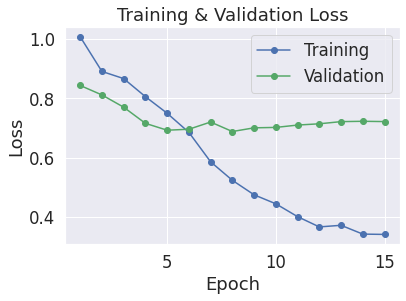

In [38]:
# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [39]:
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(news_df.shape[0]))

# Create sentence and label lists
sentences = news_df.preprocessed_title.values
labels = news_df.title_sentiment.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 156



In [40]:
# Prediction on test set

prediction_dataloader = DataLoader(
            test_dataset,  # The training samples.
            sampler = SequentialSampler(test_dataset), # Select batches sequentially
            batch_size = batch_size # Trains with this batch size.
        )


print('Predicting labels for {:,} test sentences...'.format(len(test_dataset)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 30 test sentences...
    DONE.


In [41]:
print(len(true_labels))
print(len(predictions))

1
1


In [42]:
pred_labels = []
a = 0

for i in range(len(true_labels)):
  pred_labels.append(np.argmax(predictions[i], axis=1).flatten())

pred_labels = np.concatenate(pred_labels)
true_labels = np.concatenate(true_labels)

for i in range(len(pred_labels)):
  if pred_labels[i] == true_labels[i]:
    a += 1
print('Accuracy : ', a/len(true_labels))


Accuracy :  0.8


In [43]:
print('Positive samples: %d of %d (%.2f%%)' % (news_df.title_sentiment.sum(), len(news_df.title_sentiment), (news_df.title_sentiment.sum() / len(news_df.title_sentiment) * 100.0)))

from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)


Positive samples: 199 of 156 (127.56%)
Calculating Matthews Corr. Coef. for each batch...


TypeError: ignored